In [2]:
from typing import Tuple

import matplotlib
import meep as mp
import nlopt
import numpy as np

matplotlib.use("agg")
import matplotlib.pyplot as plt


def lorentzfunc(p: np.ndarray, x: np.ndarray) -> np.ndarray:
    """
    Returns the complex ε profile given a set of Lorentzian parameters p
    (σ_0, ω_0, γ_0, σ_1, ω_1, γ_1, ...) for a set of frequencies x.
    """
    N = len(p) // 3
    y = np.zeros(len(x))
    for n in range(N):
        A_n = p[3 * n + 0]
        x_n = p[3 * n + 1]
        g_n = p[3 * n + 2]
        y = y + A_n / (np.square(x_n) - np.square(x) - 1j * x * g_n)
    return y


def lorentzerr(p: np.ndarray, x: np.ndarray, y: np.ndarray, grad: np.ndarray) -> float:
    """
    Returns the error (or residual or loss) as the L2 norm
    of the difference of ε(p,x) and y over a set of frequencies x as
    well as the gradient of this error with respect to each Lorentzian
    polarizability parameter in p and saving the result in grad.
    """
    N = len(p) // 3
    yp = lorentzfunc(p, x)
    val = np.sum(np.square(abs(y - yp)))
    for n in range(N):
        A_n = p[3 * n + 0]
        x_n = p[3 * n + 1]
        g_n = p[3 * n + 2]
        d = 1 / (np.square(x_n) - np.square(x) - 1j * x * g_n)
        if grad.size > 0:
            grad[3 * n + 0] = 2 * np.real(np.dot(np.conj(yp - y), d))
            grad[3 * n + 1] = (
                -4 * x_n * A_n * np.real(np.dot(np.conj(yp - y), np.square(d)))
            )
            grad[3 * n + 2] = (
                -2 * A_n * np.imag(np.dot(np.conj(yp - y), x * np.square(d)))
            )
    return val


def lorentzfit(
    p0: np.ndarray,
    x: np.ndarray,
    y: np.ndarray,
    alg=nlopt.LD_LBFGS,
    tol: float = 1e-25,
    maxeval: float = 10000,
) -> Tuple[np.ndarray, float]:
    """
    Returns the optimal Lorentzian polarizability parameters and error
    which minimize the error in ε(p0,x) relative to y for an initial
    set of Lorentzian polarizability parameters p0 over a set of
    frequencies x using the NLopt algorithm alg for a relative
    tolerance tol and a maximum number of iterations maxeval.
    """
    opt = nlopt.opt(alg, len(p0))
    opt.set_ftol_rel(tol)
    opt.set_maxeval(maxeval)
    opt.set_lower_bounds(np.zeros(len(p0)))
    opt.set_upper_bounds(float("inf") * np.ones(len(p0)))
    opt.set_min_objective(lambda p, grad: lorentzerr(p, x, y, grad))
    local_opt = nlopt.opt(nlopt.LD_LBFGS, len(p0))
    local_opt.set_ftol_rel(1e-10)
    local_opt.set_xtol_rel(1e-8)
    opt.set_local_optimizer(local_opt)
    popt = opt.optimize(p0)
    minf = opt.last_optimum_value()
    return popt, minf


if __name__ == "__main__":
    # Import the complex refractive index profile from a CSV file.
    # The file format is three comma-separated columns:
    #     wavelength (nm), real(n), imag(n).
    mydata = np.genfromtxt("Phys. Rev. B 27, 985-1009 (1983) Si n and k values.csv", delimiter=",")
    n = mydata[:, 1] + 1j * mydata[:, 2]

    # Fitting parameter: the instantaneous (infinite frequency) dielectric.
    # Should be > 1.0 for stability and chosen such that
    # np.amin(np.real(eps)) is ~1.0. eps is defined below.
    eps_inf = 1.1

    eps = np.square(n) - eps_inf

    # Fit only the data in the wavelength range of [wl_min, wl_max].
    wl = mydata[:, 0]
    wl_min = 399  # minimum wavelength (units of nm)
    wl_max = 701  # maximum wavelength (units of nm)
    start_idx = np.where(wl > wl_min)
    idx_start = start_idx[0][0]
    end_idx = np.where(wl < wl_max)
    idx_end = end_idx[0][-1] + 1

    # The fitting function is ε(f) where f is the frequency, rather than ε(λ).
    # Note: an equally spaced grid of wavelengths results in the larger
    #       wavelengths having a finer frequency grid than smaller ones.
    #       This feature may impact the accuracy of the fit.
    freqs = 1000 / wl  # units of 1/μm
    freqs_reduced = freqs[idx_start:idx_end]
    wl_reduced = wl[idx_start:idx_end]
    eps_reduced = eps[idx_start:idx_end]

    # Fitting parameter: number of Lorentzian terms to use in the fit
    num_lorentzians = 2

    # Number of times to repeat local optimization with random initial values.
    num_repeat = 30

    ps = np.zeros((num_repeat, 3 * num_lorentzians))
    mins = np.zeros(num_repeat)
    for m in range(num_repeat):
        # Initial values for the Lorentzian polarizability terms. Each term
        # consists of three parameters (σ, ω, γ) and is chosen randomly.
        # Note: for the case of no absorption, γ should be set to zero.
        p_rand = [10 ** (np.random.random()) for _ in range(3 * num_lorentzians)]
        ps[m, :], mins[m] = lorentzfit(
            p_rand, freqs_reduced, eps_reduced, nlopt.LD_MMA, 1e-25, 50000
        )
        ps_str = "( " + ", ".join(f"{prm:.4f}" for prm in ps[m, :]) + " )"
        print(f"iteration:, {m:3d}, ps_str, {mins[m]:.6f}")

    # Find the best performing set of parameters.
    idx_opt = np.where(np.min(mins) == mins)[0][0]
    popt_str = "( " + ", ".join(f"{prm:.4f}" for prm in ps[idx_opt]) + " )"
    print(f"optimal:, {popt_str}, {mins[idx_opt]:.6f}")

    # Define a `Medium` class object using the optimal fitting parameters.
    E_susceptibilities = []

    for n in range(num_lorentzians):
        Si_mat_freq = ps[idx_opt][3 * n + 1]
        Si_mat_gamma = ps[idx_opt][3 * n + 2]

        if Si_mat_freq == 0:
            Si_mat_sigma = ps[idx_opt][3 * n + 0]
            E_susceptibilities.append(
                mp.DrudeSusceptibility(
                    frequency=1.0, gamma=Si_mat_gamma, sigma=Si_mat_sigma
                )
            )
        else:
            Si_mat_sigma = ps[idx_opt][3 * n + 0] / Si_mat_freq**2
            E_susceptibilities.append(
                mp.LorentzianSusceptibility(
                    frequency=Si_mat_freq,
                    gamma=Si_mat_gamma,
                    sigma=Si_mat_sigma,
                )
            )

    Si_mat = mp.Medium(epsilon=eps_inf, E_susceptibilities=E_susceptibilities)

    # Plot the fit and the actual data for comparison.
    Si_mat_eps = [Si_mat.epsilon(f)[0][0] for f in freqs_reduced]

    fig, ax = plt.subplots(ncols=2)

    ax[0].plot(wl_reduced, np.real(eps_reduced) + eps_inf, "bo-", label="actual")
    ax[0].plot(wl_reduced, np.real(Si_mat_eps), "ro-", label="fit")
    ax[0].set_xlabel("wavelength (nm)")
    ax[0].set_ylabel(r"real($\epsilon$)")
    ax[0].legend()

    ax[1].plot(wl_reduced, np.imag(eps_reduced), "bo-", label="actual")
    ax[1].plot(wl_reduced, np.imag(Si_mat_eps), "ro-", label="fit")
    ax[1].set_xlabel("wavelength (nm)")
    ax[1].set_ylabel(r"imag($\epsilon$)")
    ax[1].legend()

    fig.suptitle(
        f"Comparison of Actual Material Data and Fit\n"
        f"using Drude-Lorentzian Susceptibility"
    )

    fig.subplots_adjust(wspace=0.3)
    
    plt.close(fig)

iteration:,   0, ps_str, 0.237408
iteration:,   1, ps_str, 0.236237
iteration:,   2, ps_str, 0.241092
iteration:,   3, ps_str, 2.629931
iteration:,   4, ps_str, 0.133848
iteration:,   5, ps_str, 0.211115
iteration:,   6, ps_str, 0.130254
iteration:,   7, ps_str, 0.126557
iteration:,   8, ps_str, 0.157266
iteration:,   9, ps_str, 0.135536
iteration:,  10, ps_str, 0.182793
iteration:,  11, ps_str, 0.312965
iteration:,  12, ps_str, 0.180199
iteration:,  13, ps_str, 0.132693
iteration:,  14, ps_str, 0.421940
iteration:,  15, ps_str, 0.134918
iteration:,  16, ps_str, 0.503742
iteration:,  17, ps_str, 0.811807
iteration:,  18, ps_str, 0.121902
iteration:,  19, ps_str, 0.184271
iteration:,  20, ps_str, 0.128644
iteration:,  21, ps_str, 0.211565
iteration:,  22, ps_str, 0.132327
iteration:,  23, ps_str, 0.145270
iteration:,  24, ps_str, 0.158089
iteration:,  25, ps_str, 0.133236
iteration:,  26, ps_str, 0.132041
iteration:,  27, ps_str, 0.305384
iteration:,  28, ps_str, 0.410259
iteration:,  2

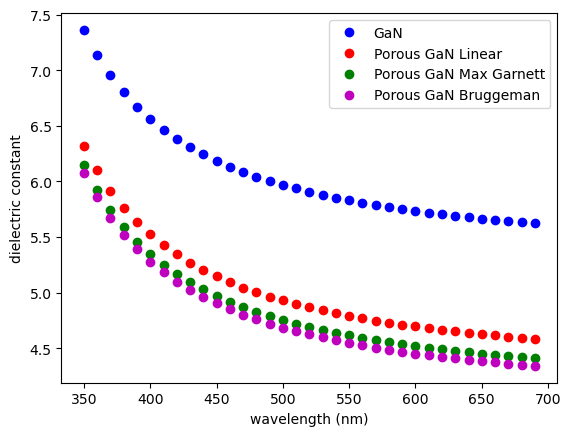

In [1]:
#Create porous GaN materials- different effective medium theories
from meep.materials import GaN,AlN
import meep as mp
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
porosity = 0.4

# gallium nitride (GaN), alpha phase (wurtzite), from A.S. Barker Jr. and M. Ilegems, Physical Review B, Vol. 7, pp. 743-50 (1973)
# ref: https://refractiveindex.info/?shelf=main&book=GaN&page=Barker-o
# ref: https://refractiveindex.info/?shelf=main&book=GaN&page=Barker-e
# wavelength range: 0.35 - 10 μm

## NOTE: ordinary (o) axes in X and Y, extraordinary (e) axis in Z
um_scale = 1.0

# conversion factor for eV to 1/μm [=1/hc]
eV_um_scale = um_scale / 1.23984193

GaN_range = mp.FreqRange(min=um_scale / 10.0, max=um_scale / 0.35)

GaN_frq1 = 1 / (0.256 * um_scale)
GaN_gam1 = 0
GaN_sig1 = 1.75
GaN_frq2 = 1 / (17.86 * um_scale)
GaN_gam2 = 0
GaN_sig2 = 4.1

GaN_susc_o = [
    mp.LorentzianSusceptibility(
        frequency=GaN_frq1, gamma=GaN_gam1, sigma_diag=GaN_sig1 * mp.Vector3(1, 1, 0)
    ),
    mp.LorentzianSusceptibility(
        frequency=GaN_frq2, gamma=GaN_gam2, sigma_diag=GaN_sig2 * mp.Vector3(1, 1, 0)
    ),
]

GaN_frq1 = 1 / (18.76 * um_scale)
GaN_gam1 = 0
GaN_sig1 = 5.08

GaN_susc_e = [
    mp.LorentzianSusceptibility(
        frequency=GaN_frq1, gamma=GaN_gam1, sigma_diag=GaN_sig1 * mp.Vector3(0, 0, 1)
    )
]

GaN = mp.Medium(
    epsilon_diag=mp.Vector3(3.6, 3.6, 5.35),
    E_susceptibilities=GaN_susc_o + GaN_susc_e,
    valid_freq_range=GaN_range,
)

porous_gan_linear=mp.Medium(
    epsilon_diag=porosity*mp.Vector3(1,1,1) + (1-porosity)*GaN.epsilon_diag,
    E_susceptibilities=GaN_susc_o + GaN_susc_e,
    valid_freq_range=GaN_range,

)
eps_x = GaN.epsilon_diag.x * (1 - (3*porosity*(GaN.epsilon_diag.x - 1))/(2*GaN.epsilon_diag.x + 1 + porosity*(GaN.epsilon_diag.x - 1)))

eps_y = GaN.epsilon_diag.y * (1 - (3*porosity*(GaN.epsilon_diag.y - 1))/(2*GaN.epsilon_diag.y + 1 + porosity*(GaN.epsilon_diag.y - 1)))

eps_z = GaN.epsilon_diag.z * (1 - (3*porosity*(GaN.epsilon_diag.z - 1))/(2*GaN.epsilon_diag.z + 1 + porosity*(GaN.epsilon_diag.z - 1)))

porous_gan_max_garnett=mp.Medium(
    
    
    epsilon_diag = mp.Vector3(eps_x, eps_y, eps_z),
    E_susceptibilities=GaN_susc_o + GaN_susc_e,
    valid_freq_range=GaN_range,
)
x_c=(3*porosity-1)*1+(3*(1-porosity)-1)*(GaN.epsilon_diag.x)
b_eps_x = (x_c+(x_c**2+8*GaN.epsilon_diag.x)**0.5)/4
y_c=(3*porosity-1)*1+(3*(1-porosity)-1)*(GaN.epsilon_diag.y)
b_eps_y = (y_c+(y_c**2+8*GaN.epsilon_diag.y)**0.5)/4
z_c=(3*porosity-1)*1+(3*(1-porosity)-1)*(GaN.epsilon_diag.z)
b_eps_z = (z_c+(z_c**2+8*GaN.epsilon_diag.z)**0.5)/4

porous_gan_bruggeman=mp.Medium(
    epsilon_diag=mp.Vector3(b_eps_x, b_eps_y, b_eps_z),
    E_susceptibilities=GaN_susc_o + GaN_susc_e,
    valid_freq_range=GaN_range,
)



for i in np.arange(350,700,10):
    plt.plot(i, GaN.epsilon(1/(i/1000))[0][0], 'bo')
    plt.plot(i, porous_gan_linear.epsilon(1/(i/1000))[0][0], 'ro')
    plt.plot(i, porous_gan_max_garnett.epsilon(1/(i/1000))[0][0], 'go')
    plt.plot(i, porous_gan_bruggeman.epsilon(1/(i/1000))[0][0], 'mo')
    plt.xlabel("wavelength (nm)")
    plt.ylabel("dielectric constant")
    plt.legend(['GaN','Porous GaN Linear','Porous GaN Max Garnett','Porous GaN Bruggeman'])
plt.show()


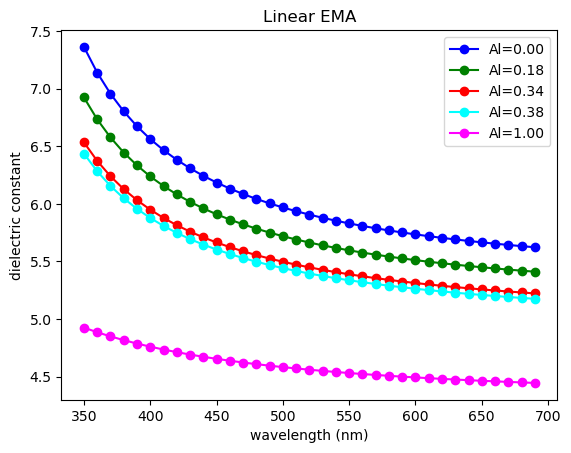

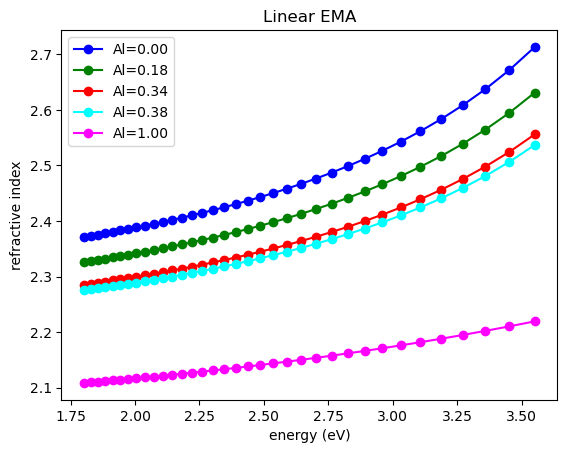

In [23]:
def AlGaN_linear(Al_comp):   
    GaN_comp = 1 - Al_comp

    # gallium nitride (GaN), alpha phase (wurtzite), from A.S. Barker Jr. and M. Ilegems, Physical Review B, Vol. 7, pp. 743-50 (1973)
    # ref: https://refractiveindex.info/?shelf=main&book=GaN&page=Barker-o
    # ref: https://refractiveindex.info/?shelf=main&book=GaN&page=Barker-e
    # wavelength range: 0.35 - 10 μm

    ## NOTE: ordinary (o) axes in X and Y, extraordinary (e) axis in Z
    um_scale = 1.0

    # conversion factor for eV to 1/μm [=1/hc]
    eV_um_scale = um_scale / 1.23984193

    GaN_range = mp.FreqRange(min=um_scale / 10.0, max=um_scale / 0.35)
    GaN_frq1 = 1 / (0.256 * um_scale)
    GaN_gam1 = 0
    GaN_sig1 = 1.75
    GaN_frq2 = 1 / (17.86 * um_scale)
    GaN_gam2 = 0
    GaN_sig2 = 4.1

    AlGaN_GaN_susc_o = [
        mp.LorentzianSusceptibility(
            frequency=GaN_frq1, gamma=GaN_gam1, sigma_diag=GaN_comp*GaN_sig1 * mp.Vector3(1, 1, 0)
        ),
        mp.LorentzianSusceptibility(
            frequency=GaN_frq2, gamma=GaN_gam2, sigma_diag=GaN_comp*GaN_sig2 * mp.Vector3(1, 1, 0)
        ),
    ]

    GaN_frq1 = 1 / (18.76 * um_scale)
    GaN_gam1 = 0
    GaN_sig1 = 5.08

    AlGaN_GaN_susc_e = [
        mp.LorentzianSusceptibility(
            frequency=GaN_frq1, gamma=GaN_gam1, sigma_diag=GaN_comp*GaN_sig1 * mp.Vector3(0, 0, 1)
        )
    ]

    # aluminum nitride (AlN) from Horiba Technical Note 08: Lorentz Dispersion Model
    # ref: http://www.horiba.com/fileadmin/uploads/Scientific/Downloads/OpticalSchool_CN/TN/ellipsometer/Lorentz_Dispersion_Model.pdf
    # wavelength range: 0.26 - 1.65 μm

    AlN_range = mp.FreqRange(min=um_scale / 1.65, max=um_scale / 0.26)

    AlN_frq1 = 1 / (0.139058089950651 * um_scale)
    AlN_gam1 = 0
    AlN_sig1 = 3.306

    AlGaN_AlN_susc = [
        mp.LorentzianSusceptibility(frequency=AlN_frq1, gamma=AlN_gam1, sigma=Al_comp*AlN_sig1)
    ]

    return mp.Medium(epsilon_diag=Al_comp*AlN.epsilon_diag + (1-Al_comp)*GaN.epsilon_diag,
                            E_susceptibilities= AlGaN_AlN_susc + AlGaN_GaN_susc_o + AlGaN_GaN_susc_e,
                            valid_freq_range=GaN_range,
                        )
colors = ['blue', 'green', 'red', 'cyan', 'magenta']
al_comps = [0,0.18,0.34,0.38,1]
for color,j in zip(colors,al_comps):  
    wavelengths = []
    epsilon_values = []
    for i in np.arange(350, 700, 10):
        wavelengths.append(i)
        epsilon_values.append(AlGaN_linear(j).epsilon(1/(i/1000))[0][0])
    plt.plot(wavelengths, epsilon_values, 'o-', color=color, label=f'Al={j:.2f}')
    plt.xlabel("wavelength (nm)")
    plt.ylabel("dielectric constant")
    plt.title("Linear EMA")
    plt.legend()
plt.show()
def eV(wl):
    return 1243.125 / wl
colors = ['blue', 'green', 'red', 'cyan', 'magenta']
al_comps = [0,0.18,0.34,0.38,1]
for color,j in zip(colors,al_comps):  
    eVs = []
    epsilon_values = []
    for i in np.arange(350,700,10):
        eVs.append(eV(i))
        epsilon_values.append((AlGaN_linear(j).epsilon(1/(i/1000))[0][0])**0.5)
    plt.plot(eVs, epsilon_values, 'o-', color=color, label=f'Al={j:.2f}')
    plt.xlabel("energy (eV)")
    plt.ylabel("refractive index")
    plt.title("Linear EMA")
    plt.legend()
plt.show()


In [22]:
eV(400)


3.1078125